In [1]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import make_swiss_roll

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
x, _ = make_swiss_roll(n_samples=10000, noise=0.5)
x = x[:, [0, 2]]
x = (x - x.mean()) / x.std()

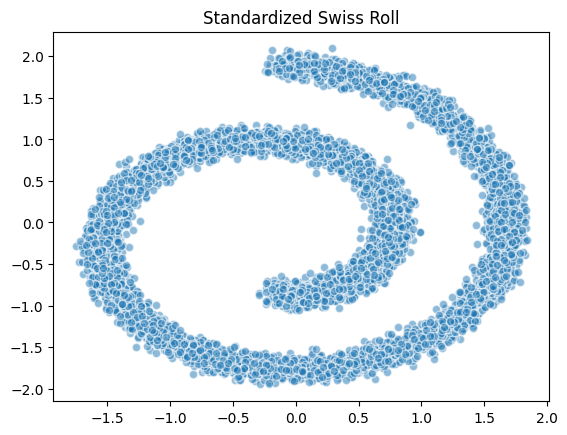

In [4]:
sns.scatterplot(x=x[:, 0], y=x[:, 1], alpha=0.5, edgecolor="white", linewidth=1)

plt.title("Standardized Swiss Roll")
plt.show()

### Datasets


In [5]:
class SamplesDataset(Dataset):
    def __init__(self, X):
        self.X = X
        self.N_samples = X.shape[0]
        self.dimension = X.shape[1]

    def __len__(self):
        return self.N_samples

    def __getitem__(self, idx):
        return self.X[idx, :]


class DiffusionDataset(Dataset):
    def __init__(self, samples_ds, T, alpha, alpha_bar, beta):
        self.samples_ds = samples_ds
        self.T = T
        self.alpha = alpha
        self.alpha_bar = alpha_bar
        self.beta = beta

    def __len__(self):
        return len(self.samples_ds)

    def noise(self, Xbatch, t):
        t_index = t.long().view(-1)  # Ensure t is a 1D long tensor
        alpha_t = torch.gather(
            self.alpha_bar, 0, t_index
        )  # Gather corresponding alphas

        # Make sure alpha_t is a 1D tensor
        if alpha_t.ndim == 0:
            alpha_t = alpha_t.unsqueeze(0)

        eps = torch.randn_like(Xbatch)

        # Apply the noise
        noised = (alpha_t**0.5).unsqueeze(1) * Xbatch + (
            (1 - alpha_t) ** 0.5
        ).unsqueeze(1) * eps
        return noised, eps

    def __getitem__(self, idx):
        # Randomly choose a time step for each sample
        t = torch.randint(0, self.T, (1,)).long()

        # Retrieve the data sample
        x0 = self.samples_ds[idx]

        # Ensure x0 is a float tensor and add an extra dimension if necessary
        if not isinstance(x0, torch.Tensor):
            x0 = torch.tensor(x0, dtype=torch.float32)
        if x0.ndim == 1:
            x0 = x0.unsqueeze(0)

        # Apply noise to the data sample
        xt, eps = self.noise(x0, t)

        # Return the noised data, time step, and actual noise
        return xt.squeeze(0), t.squeeze(), eps.squeeze(0)

### DataLoaders


In [6]:
def torch_collate(batch):
    # Assuming each element in batch is a tuple (xt, t, eps)
    if isinstance(batch[0], torch.Tensor):
        return torch.stack(batch)
    elif isinstance(batch[0], (tuple, list)):
        return [torch_collate(samples) for samples in zip(*batch)]
    else:
        raise TypeError("Batch must contain torch tensors or tuples/lists")

In [7]:
# diffusion_steps = 40
# beta_start = 1e-4
# beta_end = 0.02

# beta = torch.linspace(beta_start, beta_end, diffusion_steps)
# alpha = 1 - beta
# alpha_bar = torch.cumprod(alpha, dim=0)


#  better cosine noise schedule setup
diffusion_steps = 40
s = 0.008
timesteps = torch.tensor(range(0, diffusion_steps), dtype=torch.float32)
schedule = torch.cos((timesteps / diffusion_steps + s) / (1 + s) * torch.pi / 2) ** 2

alpha_bar = schedule / schedule[0]
beta = 1 - alpha_bar / torch.concatenate([alpha_bar[0:1], alpha_bar[0:-1]])
alpha = 1 - beta

In [8]:
samples_ds = SamplesDataset(x)
diff_ds = DiffusionDataset(samples_ds, 5, alpha, alpha_bar, beta)

diff_dl = DataLoader(diff_ds, batch_size=128, shuffle=True, collate_fn=torch_collate)

### Model


In [9]:
import torch.nn as nn
import torch.nn.functional as F


class DiffusionBlock(nn.Module):
    def __init__(self, n_units):
        super(DiffusionBlock, self).__init__()
        self.linear = nn.Linear(n_units, n_units)

    def forward(self, x: torch.Tensor):
        x = self.linear(x)
        x = nn.functional.relu(x)
        return x


class DiffusionModel(nn.Module):
    def __init__(self, dim: int, n_blocks: int = 2, n_units: int = 128):
        super(DiffusionModel, self).__init__()

        self.linearIn = nn.Linear(dim + 1, n_units)
        self.blocksSeq = nn.ModuleList(
            [DiffusionBlock(n_units) for _ in range(n_blocks)]
        )
        self.linearOut = nn.Linear(n_units, dim)

    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        if t.ndim == 1:
            t = t.unsqueeze(1)
        elif t.ndim > 2:
            raise ValueError("Time step tensor t has more than 2 dimensions")

        val = torch.hstack([x, t])
        val = self.linearIn(val)
        for blockSeq in self.blocksSeq:
            val = blockSeq(val)
        val = self.linearOut(val)
        return val

### Sampling


In [10]:
class Sampler:
    def __init__(self, diff_ds, gamma, predictor_step, step_size=None):
        self.diff_ds = diff_ds
        self.gamma = gamma
        self.predictor_step = predictor_step
        self.step_size = step_size if step_size is not None else gamma

    def DDPMSampling(self, model, nsamples, nfeatures):
        with torch.no_grad():
            x = torch.randn(size=(nsamples, nfeatures))
            diffusion_steps = self.diff_ds.T
            alphas = self.diff_ds.alpha
            alpha_bars = self.diff_ds.alpha_bar
            betas = self.diff_ds.beta

            for t in range(diffusion_steps - 1, 0, -1):
                predicted_noise = model(
                    x, torch.full([nsamples, 1], t, dtype=torch.float32)
                )
                x = (
                    1
                    / (alphas[t] ** 0.5)
                    * (
                        x
                        - (1 - alphas[t])
                        / ((1 - alpha_bars[t]) ** 0.5)
                        * predicted_noise
                    )
                )
                if t > 1:
                    variance = betas[t]
                    std = variance ** (0.5)
                    x += std * torch.randn(size=(nsamples, nfeatures))
            return x

    # def EulerMaruyamaSampling(
    #     self, model, y0, log_freq=0.1, store_intermediate_samples=False
    # ):
    #     gamma_tensor = torch.tensor(self.gamma)
    #     T = self.diff_ds.T
    #     N_langevin = int(T / self.gamma)
    #     intermediate_samples = []

    #     y = y0
    #     t = torch.zeros(y0.size(0), 1) + T

    #     for k in range(N_langevin):
    #         t -= gamma_tensor
    #         z = torch.randn_like(y)
    #         y = (
    #             y
    #             + gamma_tensor * y
    #             + 2 * gamma_tensor * model(t, y)
    #             + torch.sqrt(2 * gamma_tensor) * z
    #         )
    #         for _ in range(self.predictor_step):
    #             z = torch.randn_like(y)
    #             y = y + gamma_tensor * model(t, y) + torch.sqrt(2 * gamma_tensor) * z
    #         if store_intermediate_samples and (k % int(N_langevin / log_freq) == 0):
    #             intermediate_samples.append(y.clone().detach())

    #     if store_intermediate_samples:
    #         return intermediate_samples
    #     else:
    #         return y

### Training


In [11]:
model = DiffusionModel(dim=2, n_blocks=8)
model = model.to(device)

In [12]:
def plot_samples(samples, epoch):
    plt.figure(figsize=(4, 4))
    sns.scatterplot(
        x=samples[:, 0], y=samples[:, 1], alpha=0.5, edgecolor="white", linewidth=1
    )
    plt.axis("off")
    plt.title(f"Samples at Epoch {epoch}")
    plt.show()
    plt.close()

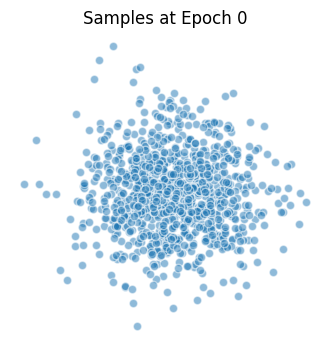

Epoch 0, Loss: 1.0524142980575562
Epoch 1, Loss: 1.232620120048523
Epoch 2, Loss: 0.783881425857544
Epoch 3, Loss: 0.9725688099861145
Epoch 4, Loss: 1.0698562860488892
Epoch 5, Loss: 1.0577752590179443
Epoch 6, Loss: 0.9448012709617615
Epoch 7, Loss: 1.210834264755249
Epoch 8, Loss: 0.7314898371696472
Epoch 9, Loss: 0.6721051335334778
Epoch 10, Loss: 0.8344077467918396
Epoch 11, Loss: 1.1280114650726318
Epoch 12, Loss: 1.2068312168121338
Epoch 13, Loss: 0.5821681618690491
Epoch 14, Loss: 0.9993419051170349
Epoch 15, Loss: 0.507824718952179
Epoch 16, Loss: 0.7953379154205322
Epoch 17, Loss: 0.9015840888023376
Epoch 18, Loss: 0.8398905396461487
Epoch 19, Loss: 1.1252176761627197
Epoch 20, Loss: 0.6617400646209717
Epoch 21, Loss: 0.9126936197280884
Epoch 22, Loss: 0.8335732221603394
Epoch 23, Loss: 0.8558409214019775
Epoch 24, Loss: 0.4229402244091034
Epoch 25, Loss: 0.9573444724082947
Epoch 26, Loss: 0.7909312844276428
Epoch 27, Loss: 0.5314061641693115
Epoch 28, Loss: 0.7843301892280579

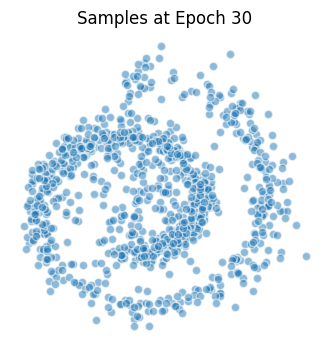

Epoch 30, Loss: 0.5720540881156921
Epoch 31, Loss: 0.7725893259048462
Epoch 32, Loss: 0.72311931848526
Epoch 33, Loss: 0.8087001442909241
Epoch 34, Loss: 1.3393471240997314
Epoch 35, Loss: 0.9522701501846313
Epoch 36, Loss: 1.0984159708023071
Epoch 37, Loss: 1.475820541381836
Epoch 38, Loss: 1.0690401792526245
Epoch 39, Loss: 0.9023360013961792
Epoch 40, Loss: 0.7204756140708923
Epoch 41, Loss: 1.4669259786605835
Epoch 42, Loss: 0.616775393486023
Epoch 43, Loss: 0.4330051839351654
Epoch 44, Loss: 0.8211968541145325
Epoch 45, Loss: 0.6604017615318298
Epoch 46, Loss: 1.002748966217041
Epoch 47, Loss: 0.8550898432731628
Epoch 48, Loss: 0.9542924165725708
Epoch 49, Loss: 1.10691499710083
Epoch 50, Loss: 0.6358556747436523
Epoch 51, Loss: 1.226150631904602
Epoch 52, Loss: 0.8834764361381531
Epoch 53, Loss: 1.2201658487319946
Epoch 54, Loss: 0.48356086015701294
Epoch 55, Loss: 0.6015167832374573
Epoch 56, Loss: 1.1354337930679321
Epoch 57, Loss: 0.8090042471885681
Epoch 58, Loss: 0.673267304

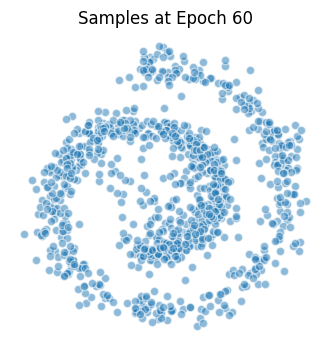

Epoch 60, Loss: 1.1113598346710205
Epoch 61, Loss: 0.8962435722351074
Epoch 62, Loss: 0.7268350124359131
Epoch 63, Loss: 0.9384047389030457
Epoch 64, Loss: 0.84993976354599
Epoch 65, Loss: 0.8327949047088623
Epoch 66, Loss: 0.7709202170372009
Epoch 67, Loss: 0.8674669861793518
Epoch 68, Loss: 0.5728244185447693
Epoch 69, Loss: 0.995009183883667
Epoch 70, Loss: 0.789786696434021
Epoch 71, Loss: 1.359054684638977
Epoch 72, Loss: 1.1947433948516846
Epoch 73, Loss: 0.9371935129165649
Epoch 74, Loss: 0.7503495812416077
Epoch 75, Loss: 0.6869158148765564
Epoch 76, Loss: 0.8594632148742676
Epoch 77, Loss: 0.6885160207748413
Epoch 78, Loss: 0.6553517580032349
Epoch 79, Loss: 1.1153302192687988
Epoch 80, Loss: 0.6840180158615112
Epoch 81, Loss: 0.4827762246131897
Epoch 82, Loss: 0.8877692222595215
Epoch 83, Loss: 0.7569797039031982
Epoch 84, Loss: 0.7854976058006287
Epoch 85, Loss: 0.7145518064498901
Epoch 86, Loss: 0.7432929277420044
Epoch 87, Loss: 1.227844476699829
Epoch 88, Loss: 0.71772623

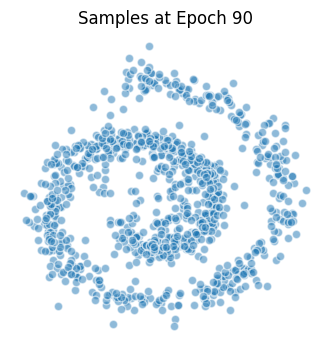

Epoch 90, Loss: 1.466137409210205
Epoch 91, Loss: 0.8796125650405884
Epoch 92, Loss: 0.8485450148582458
Epoch 93, Loss: 0.49610430002212524
Epoch 94, Loss: 0.5470837950706482
Epoch 95, Loss: 0.6857673525810242
Epoch 96, Loss: 0.9997276067733765
Epoch 97, Loss: 0.5614765286445618
Epoch 98, Loss: 0.6967803239822388
Epoch 99, Loss: 0.662889838218689
Epoch 100, Loss: 1.1392301321029663
Epoch 101, Loss: 0.6000187397003174
Epoch 102, Loss: 0.9089629650115967
Epoch 103, Loss: 0.698080837726593
Epoch 104, Loss: 1.109609603881836
Epoch 105, Loss: 0.5340474247932434
Epoch 106, Loss: 0.8387099504470825
Epoch 107, Loss: 0.6953529119491577
Epoch 108, Loss: 0.7259833216667175
Epoch 109, Loss: 0.9157987236976624
Epoch 110, Loss: 0.5171867609024048
Epoch 111, Loss: 0.6934318542480469
Epoch 112, Loss: 1.095674991607666
Epoch 113, Loss: 0.8482999205589294
Epoch 114, Loss: 0.8937214612960815
Epoch 115, Loss: 0.722944438457489
Epoch 116, Loss: 1.0583728551864624
Epoch 117, Loss: 0.898790717124939
Epoch 11

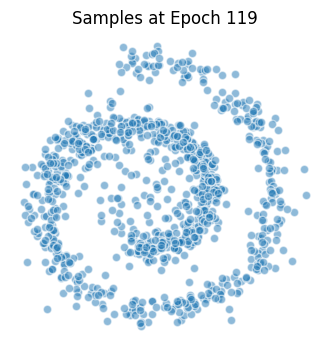

Epoch 119, Loss: 0.8931771516799927


In [13]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

sampler = Sampler(diff_ds, None, None)
nsamples = 1000
dim = 2

n_epochs = 120
for epoch in range(n_epochs):
    epoch_loss = 0
    for xt, t, eps in diff_dl:
        t = t.to(torch.float32)
        xt = xt.to(torch.float32)  # Noised data
        eps = eps.to(torch.float32)  # Actual noise

        optimizer.zero_grad()
        predicted_noise = model(xt, t)
        loss = loss_fn(predicted_noise, eps)
        loss.backward()
        optimizer.step()

    if epoch % 30 == 0 or epoch == n_epochs - 1:
        # Plot samples
        ddpm_samples = sampler.DDPMSampling(model, nsamples, dim)
        plot_samples(ddpm_samples, epoch)

    print(f"Epoch {epoch}, Loss: {loss.item()}")

In [14]:
ddpm_samples = sampler.DDPMSampling(model, nsamples, dim)

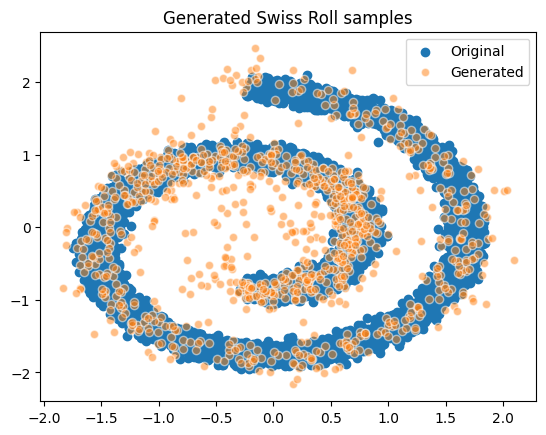

In [15]:
# Visualization of the generated samples
plt.scatter(x[:, 0], x[:, 1])
sns.scatterplot(
    x=ddpm_samples[:, 0].detach().numpy(),
    y=ddpm_samples[:, 1].detach().numpy(),
    alpha=0.5,
    edgecolor="white",
    linewidth=1,
)
plt.legend(["Original", "Generated"])
plt.title("Generated Swiss Roll samples")
plt.show()